In [ ]:
import glob
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline

from skimage.morphology import ball
from skimage import measure, feature
from skimage.morphology import binary_dilation, binary_opening, binary_closing
from skimage.filters import roberts, sobel
from skimage.measure import label,regionprops, perimeter

from sklearn import cross_validation
import xgboost as xgb

import tensorflow as tf
import tflearn
from cnn_model import CNNModel

In [2]:
FEATURE_DIR = '/notebooks/DSB3/data/stage1/stage1/'
INPUT_DATA_DIR = '/notebooks/DSB3/data/stage1_lungs_npy/'
OUTPUT_DATA_DIR = '/notebooks/ashish/seg_feats_2/'
model_file = 'nodule3-classifier.tfl'

In [3]:
tf.reset_default_graph()

IMG_SIZE = 50
input_shape = np.zeros((1, IMG_SIZE, IMG_SIZE, 1))

convnet = CNNModel()
fc_layer, network = convnet.define_network(input_shape, 'fc_feat')

model = tflearn.DNN(network, tensorboard_verbose=0)
model.load(model_file)

fc_model = tflearn.DNN(fc_layer, session = model.session)

In [4]:
def get_subimage(image, center, width):
    """
    Returns cropped image of requested dimensiona
    """
    z, y, x = center
    subImage = image[int(z), int(y-width/2):int(y+width/2), int(x-width/2):int(x+width/2)]
    return subImage.copy()

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

def segment_nodules(segmented_ct_scan):
    segmented_ct_scan[segmented_ct_scan < -30] = 0
    segmented_ct_scan[segmented_ct_scan > 400] = 0
    
    selem = ball(2)
    binary = binary_closing(segmented_ct_scan, selem)
    
    return binary

def can_crop_image(image, center, width):
    z, y, x = center
    if int(z) >= image.shape[0] or int(y-width/2) < 0 or int(y+width/2) >= image.shape[1] or int(x-width/2) < 0 or int(x+width/2) >= image.shape[2]:
        return False
    else:
        return True

def contains_nodule(region, lungs):
    ## check if it classified as nodule based on model built using luna16 data
    center = region.coords.mean(axis=0)
    if can_crop_image(lungs, center, IMG_SIZE):
        img_chip = get_subimage(lungs, center, IMG_SIZE)
        img_chip_norm = normalizePlanes(img_chip)
    else:
        return False
    
    if img_chip_norm.shape[0] == IMG_SIZE and img_chip_norm.shape[1] == IMG_SIZE:
        prediction = model.predict(img_chip_norm.reshape((1,img_chip_norm.shape[0], img_chip_norm.shape[1], 1)))
        return (prediction[0][1] > 0.95)
    else:
        return False

In [5]:
def segmented_nodules_feats(segmented_ct_scan):
    binary = segment_nodules(segmented_ct_scan.copy())
    label_scan = label(binary)
    regions = regionprops(label_scan)

    areas = [r.area for r in regions]
    areas.sort()
    ############################
    
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    eqDiameters = []
    final_regions = []

    for r in regions:
        max_x, max_y, max_z = 0, 0, 0
        min_x, min_y, min_z = 1000, 1000, 1000

        for c in r.coords:
            max_z = max(c[0], max_z)
            max_y = max(c[1], max_y)
            max_x = max(c[2], max_x)

            min_z = min(c[0], min_z)
            min_y = min(c[1], min_y)
            min_x = min(c[2], min_x)
            
        has_nodule = contains_nodule(r, segmented_ct_scan)
        if (min_z == max_z or min_y == max_y or min_x == max_x 
            or r.area > areas[-3] 
            or (max_z - min_z) < 1 
            or (max_z - min_z) > 30 
            or not has_nodule):
            for c in r.coords:
                segmented_ct_scan[c[0], c[1], c[2]] = 0
                binary[c[0], c[1], c[2]] = 0
        else:
            final_regions.append(r)
            
        #########
        if r.area > maxAllowedArea or not has_nodule:
            continue
            
        totalArea += r.area
        #avgEcc += region.eccentricity
        avgEquivlentDiameter += r.equivalent_diameter
        eqDiameters.append(r.equivalent_diameter)
        
    numNodes = len(final_regions) + 1
    final_areas = [r.area for r in final_regions] + [0]
    maxArea = max(final_areas)
    avgArea = totalArea / numNodes
    #avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters + [0])
    stdAreas = np.std(final_areas)
    
    return binary, segmented_ct_scan, np.array([totalArea, avgArea, maxArea, avgEquivlentDiameter,\
                     stdEquivlentDiameter, numNodes, stdAreas])

In [6]:
#orig_data = np.load('/notebooks/DSB3/data/stage1_lungs_npy/2d596b6ead89ab35577fe625a9a17cbb.npy')
#tmp, tmp1, feats = segmented_nodules_feats(orig_data)
#print (feats)

In [7]:
def extract_and_save_features(input_file):
    out_file_path = OUTPUT_DATA_DIR + os.path.basename(input_file)
    if os.path.isfile(out_file_path):
        print(out_file_path + " already created.")
    else:
        print ("Creating file: %s" % out_file_path)
        orig_data = np.load(input_file)
        tmp, tmp1, feats = segmented_nodules_feats(orig_data)
        np.save(out_file_path, feats)   

In [ ]:
## perform segmentation and save off numpy binary
for input_file in reversed(glob.glob(INPUT_DATA_DIR + '*.npy')):
    extract_and_save_features(input_file)

In [19]:
## generate Dataframe out of it
feat_list = []
pid_list = []
for input_file in glob.glob(OUTPUT_DATA_DIR + '*.npy'):
    feat_list.append(np.load(input_file))
    pid_list.append(os.path.basename(input_file)[:-4])

df = pd.DataFrame(feat_list, columns=['totArea', 'avgArea', 'maxArea', 'avgEquDiam', 'stdEquDiam', 'numNodes', 'stdArea'])
df['id'] = pid_list

print ("number of rows", len(df))
df.head()

#df.to_csv('/notebooks/ashish/features_csv/luna16_nodule_detected_feats.csv', index=False)

('number of rows', 1595)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f510819cbd0>,
 <matplotlib.text.Text at 0x7f5100f81350>)

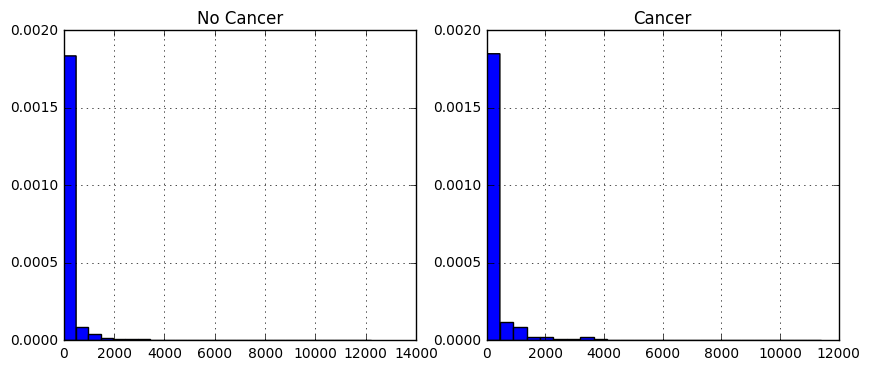

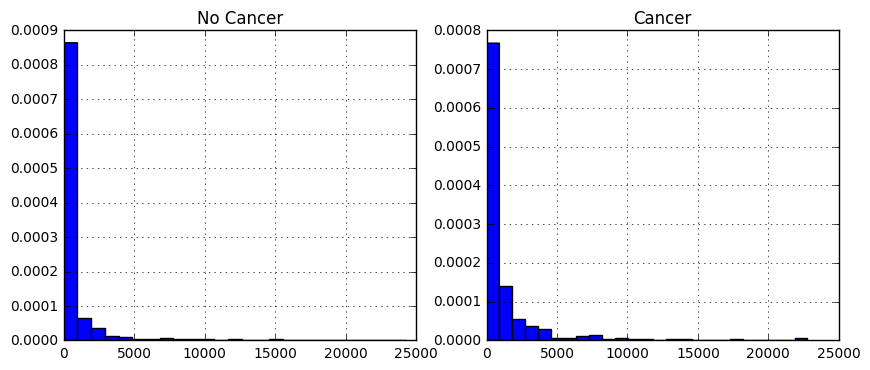

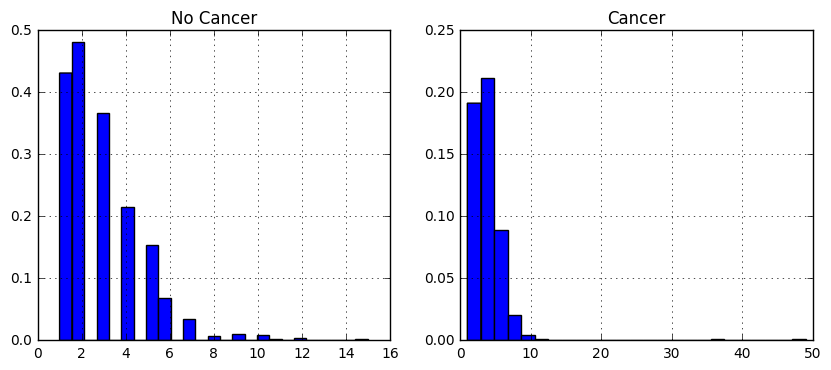

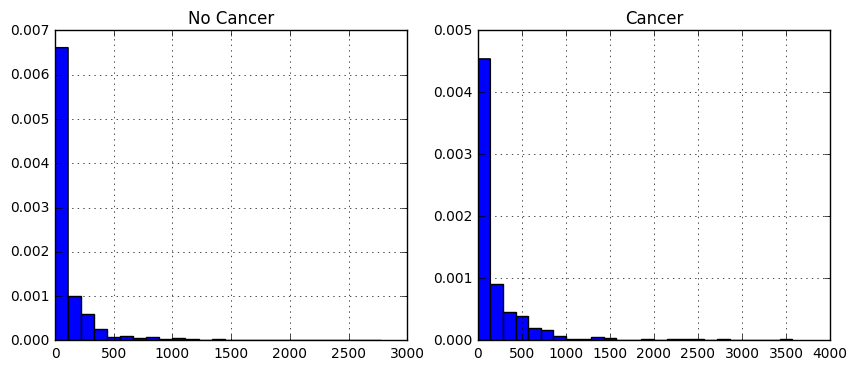

In [15]:
plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1), df_train[df_train.cancer == 0].avgArea.hist(normed=1, bins=25), plt.title('No Cancer')
plt.subplot(1,2,2), df_train[df_train.cancer == 1].avgArea.hist(normed=1, bins=25), plt.title('Cancer')

plt.figure(2, figsize=(10,4))
plt.subplot(1,2,1), df_train[df_train.cancer == 0].totArea.hist(normed=1, bins=25), plt.title('No Cancer')
plt.subplot(1,2,2), df_train[df_train.cancer == 1].totArea.hist(normed=1, bins=25), plt.title('Cancer')

plt.figure(3, figsize=(10,4))
plt.subplot(1,2,1), df_train[df_train.cancer == 0].numNodes.hist(normed=1, bins=25), plt.title('No Cancer')
plt.subplot(1,2,2), df_train[df_train.cancer == 1].numNodes.hist(normed=1, bins=25), plt.title('Cancer')

plt.figure(4, figsize=(10,4))
plt.subplot(1,2,1), df_train[df_train.cancer == 0].stdArea.hist(normed=1, bins=25), plt.title('No Cancer')
plt.subplot(1,2,2), df_train[df_train.cancer == 1].stdArea.hist(normed=1, bins=25), plt.title('Cancer')